# MVP
### Regression-like

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('mvp_votings.csv', index_col=0)

## Data Understanding

In [3]:
df.head()

,fga,fg3a,fta,per,ts_pct,usg_pct,bpm,season,player,win_pct,...,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,fg_pct,fg3_pct,ft_pct,ws,ws_per_48
0,18.6,0.2,6.5,25.1,0.572,28.4,8.0,1980-81,Julius Erving,0.756098,...,24.6,8.0,4.4,2.1,1.8,0.521,0.222,0.787,13.8,0.231
1,18.3,0.9,4.0,19.9,0.528,24.3,5.1,1980-81,Larry Bird,0.756098,...,21.2,10.9,5.5,2.0,0.8,0.478,0.270,0.863,10.8,0.160
2,18.2,0.0,6.9,25.5,0.616,26.3,5.3,1980-81,Kareem Abdul-Jabbar,0.658537,...,26.2,10.3,3.4,0.7,2.9,0.574,0.000,0.766,14.3,0.230
3,19.3,0.0,10.1,25.1,0.585,27.6,3.7,1980-81,Moses Malone,0.487805,...,27.8,14.8,1.8,1.0,1.9,0.522,0.333,0.757,13.7,0.202
4,21.1,0.4,7.6,22.9,0.555,32.3,1.6,1980-81,George Gervin,0.634146,...,27.1,5.1,3.2,1.1,0.7,0.492,0.257,0.826,10.5,0.182


In [4]:
# The target
df['award_share'].head()

0    0.658
1    0.613
2    0.414
3    0.261
4    0.120
Name: award_share, dtype: float64

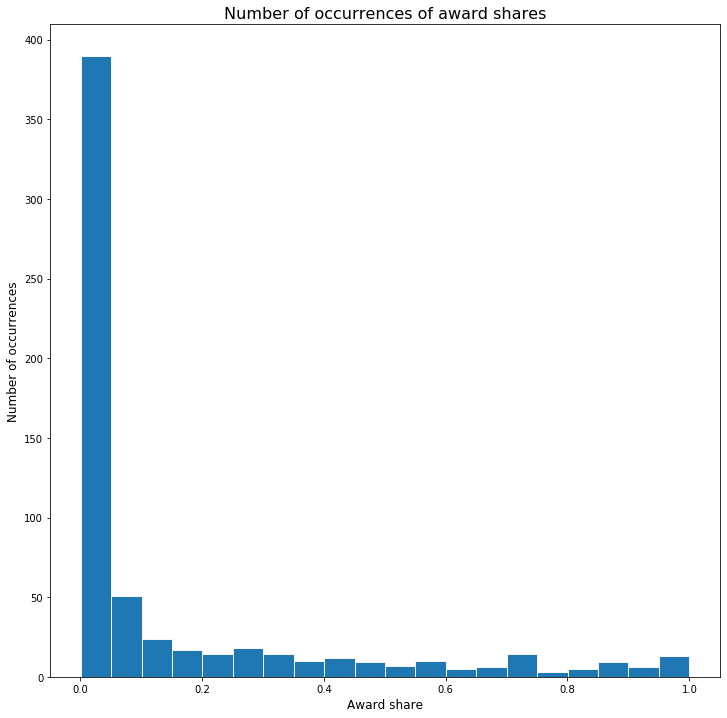

In [5]:
# Distribution of target
plt.figure(figsize=(12, 12))
plt.hist(df.award_share, bins=20, edgecolor='#F5F5F5')
plt.title('Number of occurrences of award shares', size=16)
plt.ylabel('Number of occurrences', size=12)
plt.xlabel('Award share', size=12);

## Feature selection

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor

In [7]:
orig_features = ['fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
                 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
                 'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct',
                 'ws', 'ws_per_48', 'win_pct']

In [8]:
x_data = df[orig_features].to_numpy()
y_data = df[['award_share']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

In [9]:
x_data.shape, y_data.shape

((637, 19), (637,))

### Random Forest to check most important features

In [10]:
regressor = RandomForestRegressor(n_estimators=200)

In [11]:
regressor.fit(x_data, y_data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [12]:
sorted_indices = np.argsort(regressor.feature_importances_)[::-1]

In [13]:
for index in sorted_indices:
    print(f"{orig_features[index]}: {regressor.feature_importances_[index]}")

ws: 0.3910656889811732
win_pct: 0.127699358417896
per: 0.09539880889571982
bpm: 0.061298644087540245
ws_per_48: 0.03860909295009526
fga: 0.03461178838953478
usg_pct: 0.032417964439429875
ft_pct: 0.026190466494309495
fg_pct: 0.024334805664071514
ast_per_g: 0.023164050714213107
mp_per_g: 0.023155797907253427
fta: 0.022211857778855988
pts_per_g: 0.017772913776578938
trb_per_g: 0.01724964320045591
ts_pct: 0.0171304862508583
fg3_pct: 0.016309682204383252
blk_per_g: 0.01122458497858767
fg3a: 0.010649480036336098
stl_per_g: 0.009504884832707004


### Performing feature selection

In [14]:
selector = SelectKBest(mutual_info_regression, k=5)

In [15]:
best_features = selector.fit_transform(x_data, y_data)

In [16]:
sorted_indices = np.argsort(selector.scores_)[::-1]

In [17]:
for index in sorted_indices:
    print(f"{orig_features[index]}: {selector.scores_[index]:.4f}")

ws: 0.2992
per: 0.2736
ws_per_48: 0.2504
bpm: 0.2119
pts_per_g: 0.1559
win_pct: 0.1058
usg_pct: 0.1048
fta: 0.0801
ts_pct: 0.0794
fga: 0.0753
mp_per_g: 0.0697
trb_per_g: 0.0589
stl_per_g: 0.0339
ft_pct: 0.0332
fg3a: 0.0310
ast_per_g: 0.0214
fg_pct: 0.0191
fg3_pct: 0.0089
blk_per_g: 0.0000


### Correlation matrix

In [18]:
data = df[orig_features + ['award_share']]

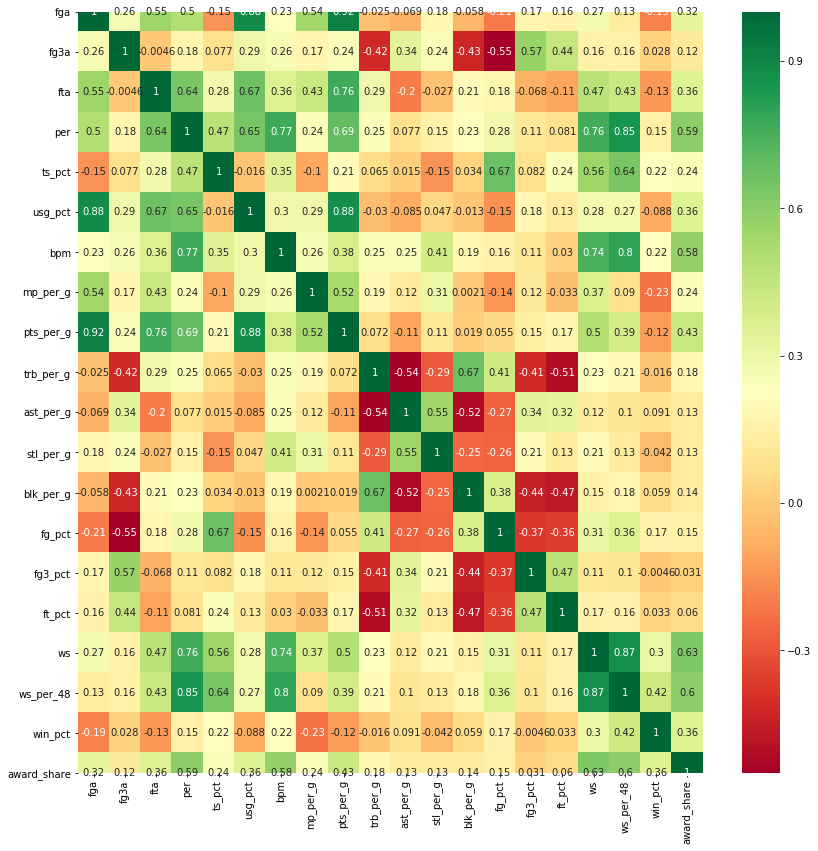

In [19]:
fig = plt.figure(figsize=(14,14))
fig.set_facecolor('white')
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn');

In [40]:
features = ['ts_pct', 'bpm', 'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
            'stl_per_g', 'blk_per_g', 'ws', 'win_pct']

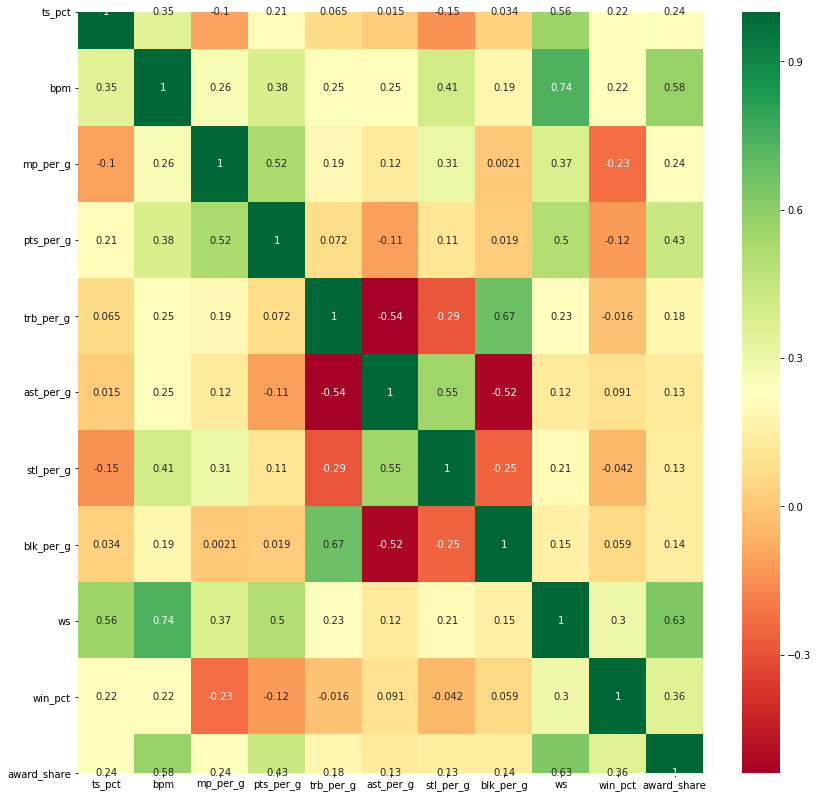

In [42]:
data = df[features + ['award_share']]
fig = plt.figure(figsize=(14,14))
fig.set_facecolor('white')
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
_ = plt.yticks(rotation='horizontal')

## Training and Validation

Cross-validation by using all seasons for training, except one season, used for validation.

## Pipeline

In [3]:
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import logging

In [5]:
def pipeline(data_frame, estimators, params, filename, poly_fit=None, scaler=None):
    seasons = data_frame.season.unique()
    features = ['ts_pct', 'bpm', 'usg_pct', 'pts_per_g', 'trb_per_g', 'per', 'ws_per_48', 'win_pct']
    target = ['award_share']
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename, filemode='w', level=logging.INFO)
    logger = logging.getLogger()
    
    minimal_error, best_estimator = None, None
    
    for estimator in estimators:
        try:
            print(f"Starting with estimator: {estimator.__name__}")
            logging.info(f"Starting with estimator: {estimator.__name__}")
            
            for index, cur_params in enumerate(params[estimator.__name__]):
                regressor = estimator(**cur_params)
                errors = [] # MSE for each split
                accuracies = [] # accuracies for each split
                best_accuracies = []
                
                for season in seasons:
                    train_data = data_frame.loc[data_frame.season != season]
                    validation_data = data_frame.loc[data_frame.season == season]
                    validation_data = validation_data.sort_values(by='award_share', ascending=False)
                    
                    # Get train data
                    train_x = train_data[features].to_numpy()
                    train_y = train_data[target].to_numpy()
                    train_y = train_y.reshape(train_y.shape[0], )
                    
                    # Validate over one season only
                    val_x = validation_data[features].to_numpy()
                    val_y = validation_data[target].to_numpu()
                    val_y = val_y.reshape(val_y.shape[0], )
                    
                    if poly_fit:
                        train_x = poly_fit.fit_transform(train_x)
                        val_x = poly_fit.fit_transform(val_x)
                        
                    if scaler:
                        train_x = scaler.fit_transform(train_x)
                        val_x = scaler.fit_transform(val_x)
                        
                    shuffle_x, shuffle_y = shuffle(train_x, train_y)
                    
                    regressor.fit(shuffle_x, shuffle_y)
                    predicted_y = regressor.predict(val_x)
                    
                    sorted_indices = np.argsort(predicted_y)[::-1]
                    correct_indices = np.arange(len(val_y))
                    
                    accuracy = np.sum(sorted_indices[:5] == correct_indices[:5] / len(correct_indices[:5]))
                    accuracies.append(accuracy)
                    
                    best_accuracies.append(np.sum(sorted_indices[:1] == correct_indices[:5]) / len(correct_indices[:1]))
                    
                    curr_error = mean_squared_error(val_y, predicted_y)
        except Exception:
            print(f"Exception: {estimator}")
            continue
        
    return best_estimator